# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.7 which is incompatible.


The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
#env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 3. algorithm - DDPG

Deep Deterministic Policy Gradiant (DDPG) can solve problem with continuous action space. This algorithm use two neural networks (actor-critic):

actor network: a policy network which maps states to actions

- 1st hidden layer: fully-connected linear layer with 256 rectifier units,
- 2nd hidden layer: fully-connected linear layer with 128 rectifier units,
- output layer: fully-connected linear layer with 4 output nodes following by a tanh() activation function

critic network: a value function network which maps (states, actions) to Q_values

- 1st hidden layer: fully-connected linear layer with 256 rectifier units,
- 2nd hidden layer: fully-connected linear layer with 128 rectifier units, input size of this layer is (256 + action_size)
- output layer: fully-connected linear layer with 1 output nodes without nonlinearity

At each time step:

- the actor_local receive `states` and ouput `actions`, these actions are sent with a `noise` to the environment for `next_states` and `rewards`
- store the experiences (including states, actions, rewards, next_states) in a memory pool
- sample a batch of experiences from the memory pool
- calculate target critic value and local critic value, and then calculate the `critic_loss`
- perform a grediant descent step on the `critic_loss` and update `critic_local` network parameters
- calculate `J` value and perform a grediant descent step on `-J`, then update `actor_local` network parameters
- soft update the `critic_target` and `actor_target` network parameters

In [5]:
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
import torch
# hyperparameters
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor
LR_CRITIC = 1e-4        # learning rate of the critic

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
from DDPG_agent import Agent, ReplayBuffer, OUNoise
seed = 0
agent = Agent(device, num_agents, brain.vector_observation_space_size, brain.vector_action_space_size, seed,
              BUFFER_SIZE, BATCH_SIZE, GAMMA, TAU, LR_ACTOR, LR_CRITIC)
noise = OUNoise((num_agents, brain.vector_action_space_size),seed)

cuda:0


Episode :157	Score :38.21	Average Score :30.225179324414583
Environment solved at Episode 157, average score = 30.23


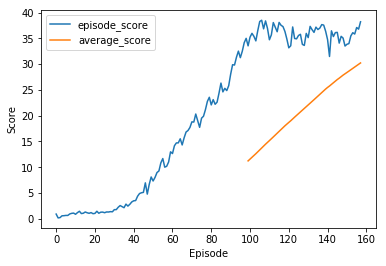

In [7]:
import torch

def DDPG_train(num_episodes=500):
    scores = []
    scores_window = deque(maxlen=100)
    average_scores = []
    for i in range(num_episodes):
        brain_info = env.reset(train_mode=True)[brain_name]  # reset the environment
        states = brain_info.vector_observations               # get the current state
        score = np.zeros(num_agents)                          # initialize the score
        noise.reset()                                         # reset noise for each episode
        while True:
            actions = np.clip(agent.act(states) + noise.sample(), -1, 1)      # add noise to actions
            brain_info = env.step(actions)[brain_name]                        # send the action to the environment
            next_states = brain_info.vector_observations                      # get the next state
            rewards = brain_info.rewards                                      # get the reward
            dones = brain_info.local_done                                     # see if episode has finished
            score += rewards                                                  # update the score
            agent.step(states, actions, rewards, next_states, dones)        
            if np.any(dones):                                                 # exit loop if episode finished
                break
            states = next_states                                              # roll over the state to next time step
        scores.append(np.mean(score))
        scores_window.append(np.mean(score))
        if len(scores_window)==100:
            average_scores.append(np.mean(scores_window))

        else:
            average_scores.append(None)
        print("\rEpisode :{}\tScore :{:.2f}\tAverage Score :{}".format(i, scores[i], average_scores[i]), end="")

        if i>=100 and average_scores[i]>30.0:
            print("\nEnvironment solved at Episode {}, average score = {:.2f}".format(i,average_scores[i]))
            break

    torch.save(agent.actor_local.state_dict(), 'actor_checkpoint.pth')
    torch.save(agent.critic_local.state_dict(), 'critic_checkpoint.pth')

    fig = plt.figure()
    plt.plot(np.arange(len(scores)), scores, label="episode_score")
    plt.plot(np.arange(len(average_scores)), average_scores, label="average_score")
    plt.legend()
    plt.xlabel("Episode")
    plt.ylabel("Score")
    plt.show()

from workspace_utils import active_session

with active_session():
    DDPG_train(num_episodes=500)

### Future implementation

I am interested in the  Distributed Distributional Deep Deterministic Policy Gradient algorithm (D4PG). Next step i would try this algorithm.